In this notebook we will develop the necessary code to perform the different simulations, and save the results to be analyzed later.

In [8]:
# Import modules
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Designing the simulations

We will proceed in an object oriented manner, and implement the Gillespie algorithm for stochastic simulations.

In [379]:
# Initialize the universal Simulation class
# over a custom network
class Sim(object):
    def __init__(self, N, I_0, M, m, beta, gamma):
        '''
        Params:
            N : numpy array
                Array of shape (L,) containing the initial size of
                each population.
            I_0 : numpy array
                Array of shape (L,) containing the initial amount of
                infected individuals in each population.
            M : numpy array
                Array of shape (L,L) with the mobility fractions M_ij
                from population i to population j.
            m : int 
                Number of infection stages.
            beta : numpy array
                Array of shape (m,) with the infection rates for each 
                infection stage. The timescale must be one hour.
            gamma : numpy array
                Array of shape (m,) with the transition rates from 
                each infection stage into the next one (or recovered
                state). The timescale must be one hour.
        '''
        # Population parameters
        self.N = np.array(N)
        self.I_0 = np.array(I_0)
        self.M = np.array(M)
        
        # Infection parameters
        self.m = m 
        self.beta = np.array(beta)
        self.gamma = np.array(gamma)
        
        # Initialize simulation info
        self.t = [0]
        init_state = []
        for i in range(len(N)):
            i_state = [N[i] - I_0[i], I_0[i]]
            for j in range(m):
                i_state.append(0)
            init_state.append(i_state)
        self.state = np.array(init_state)
        
        self.history = [self.state.copy()]
        self.tot_history = [np.sum(self.state, 0)]
        self.elapsed_time = None
        
        
# Now, we need to define the kernel-transmission (KT) model
# for humans
class SimKTHuman(Sim):
    def __init__(self, N, I_0, M, m, beta, gamma):
        super().__init__(N, I_0, M, m, beta, gamma)
        
    # Function to calculate force of infection
    def FOI(self, t):
        '''
        Params:
            t : float
                Current time in the dynamics of the system, 
                in a timescale of hours.
        Output:
            Calculates the force of infection (FOI) for each
            population using the kernel-transmission model.
        '''    
        # Get current infecteds
        I = self.state[:,1:self.m+1]
        
        # Calculate differently for day-time and night-time
        if t % 24 >= 16:
            # Day-time
            beta_term = np.einsum('i,ji->j', self.beta, I)
            N_inv_term = 1 / np.einsum('l,lk->k', self.N, self.M)
            M_term = np.einsum('ik, jk, k -> ij', 
                               self.M, self.M, N_inv_term)
            lambdas = np.einsum('j,ij -> i', beta_term, M_term)
            
        else:
            # Night-time
            beta_term = np.einsum('i,ji->j', self.beta, I)
            N_inv = 1 / self.N.astype('float')
            lambdas = np.einsum('i,i->i', beta_term, N_inv)
            
        # Set FOI and return it
        self.current_FOI = lambdas
        return lambdas
    
    
    # Function to run the simulation    
    def run(self, verbose=True, tol=int(1e6)):
        '''
        Params:
            verbose : bool (optional)
                Whether to print information while running the
                simulation. Default is True.
            tol : int (optional)
                Amount of iterations to tolerate before forcing
                the termination of the simulation. Default is 
                1e6 iterations.
        Output:
            Performs a kernel-transmission model simulation. The 
            simulation is ended when there are no more infectious
            individual in the entire system, or the iterations
            tolerance is reached. The sampled times in the Gillespie 
            scheme are in a timescale of one hour.
        '''
        # Centinel variables
        running = True
        iters = 0
        
        # Start timing
        t1 = time.time()
        
        # Init current dynamics time
        t = self.t[-1]
        
        # Iterate until termination is reached
        while running:
            iters += 1
            
            # Get FOI
            FOI = self.FOI(t)
            
            # Build a list with all the rates 
            # in the system
            # Infection rates: FOI * S
            rates = list(np.einsum('i,i->i', FOI, self.state[:,0]))
            # Gamma, one for each stage, repeated
            # for each population:
            rates.extend(
                [self.gamma[i]*self.state[j,i+1] for i in range(self.m)\
                 for j in range(len(self.N))])
            
            rate_tot = np.sum(rates)
            
            # Draw a new time value
            new_t = np.random.exponential(scale=1/rate_tot)
            
            # Define transition probabilities
            probs = np.array(rates) / rate_tot
            
            # Choose a transition
            T_id = np.random.choice(np.arange(len(probs)), p=probs)
            
            # Affected population and process id
            pop_i = T_id % len(self.N)
            proc_id = T_id // len(self.N)
            
            # Update state
            new_state = self.state.copy()
            new_state[pop_i, proc_id] -= 1
            new_state[pop_i, proc_id+1] += 1
            self.state = new_state.copy()
            
            # Update history
            self.history.append(new_state)
            self.tot_history.append(np.sum(new_state, 0))
            
            
            # Update time
            t += new_t
            self.t.append(t)
            
            # Check for termination
            tot_I = np.sum(self.tot_history[-1][1:self.m+1])
            if tot_I < 1:
                running = False
                
            if iters > tol:
                running = False
                
        # Finish timing
        t2 = time.time()
        
        # Store elapsed time
        self.elapsed_time = t2 - t1
        if verbose:
            mins = (t2-t1)//60
            secs = round((t2-t1) % 60)
            print(f'Process finished in {mins} minutes and {secs} seconds.')
            
        # Turn history into numpy array
        hist = self.history
        self.history = np.array(hist)

        return self.t, self.history
    
    
    # Function to get infection peak time difference 
    # between two populations
    def I_peak_time_diff(self, i, j):
        '''
        Params:
            i, j : int
                Index of the populations for which to calculate
                the peak time difference.
        Output:
            Returns the time difference between the infection 
            peaks of populations i and j.
        '''
        # Gather data for the selected populations
        data_i = np.sum(self.history[:,i,1:self.m+1], axis=-1)
        data_j = np.sum(self.history[:,j,1:self.m+1], axis=-1)
        
        # Find the indexes for the maximum for each population
        argmax_i = np.argmax(data_i)
        argmax_j = np.argmax(data_j)
        
        # Get time difference
        delta_t = self.t[argmax_i] - self.t[argmax_j]
        return delta_t
    
    
    
# Then, let us develop the random movers (RM) model
# for humans
class SimRMHuman(Sim):
    def __init__(self, N, I_0, M, m, beta, gamma):
        super().__init__(N, I_0, M, m, beta, gamma)
        # In this case, we need to account for specific
        # individual mobility, and so we need to keep 
        # track of the origin of each individual
        indiv = {'Home': [],    # Home population
                 'Commute': [], # Commute location
                 'State': []}   # Infectious state
        
        # Let us define the individual data
        for pop in range(len(self.N)):
            for i in range(self.N[pop]):    
                # Add home id
                indiv['Home'].append(pop)
                
                # Add infectious state
                if i < I_0[pop]:
                    indiv['State'].append(1)
                else:
                    indiv['State'].append(0)
                    
            # Add commuting ids
            N_j = np.round(self.N[pop] * self.M[pop,:]).astype('int')
            for j in range(len(N_j)):
                for n in range(N_j[j]):
                    indiv['Commute'].append(j)
        
        # Turn into DataFrame and save as attribute
        self.indiv = pd.DataFrame(indiv)
        
        # Define a single state tensor with all data
        # and a total population tensor
        self.state_tensor = None
        self.N_tensor = None
        
        
    # Function to initialize the state tensor
    def init_state_tensor(self):
        # Get current data and number of populations
        arr = np.array(self.indiv)
        L = len(self.N)
        
        # Get state tensor
        tens = []
        for i in range(self.m+2):
            state_mask = arr[:,2] == i
            i_layer = []
            for j in range(L):
                comm_mask = state_mask * (arr[:,1] == j)
                j_layer = []
                for k in range(L):
                    home_mask = comm_mask * (arr[:,0] == k)
                    j_layer.append(np.sum(home_mask))
                i_layer.append(j_layer)
            tens.append(i_layer)
        
        # Set attribute: state tensor
        # Indexed as (i,j,k)->(state, comm, home)
        self.state_tensor = np.array(tens) 
        
        # State attribute: population tensor
        # Indexed as (j,k) -> (comm, home)
        self.N_tensor = np.sum(self.state_tensor, axis=0)
        
    
    # Function to rebuild individual level data
    def set_indiv_data(self):
        '''
        Output:
            Updates the individual level data of the system
            from the current state tensor.
        '''
        # Get number of populations
        L = len(self.N)
        
        # Init empty data
        indiv = {'Home': [],    # Home population
                 'Commute': [], # Commute location
                 'State': []}   # Infectious state
        
        # Retrieve the individual data from the state 
        # tensor counts
        for i in range(self.m+2):
            for j in range(L):
                for k in range(L):
                    counts = self.state_tensor[i,j,k]
                    indiv['Home'].extend([k for n in range(counts)])
                    indiv['Commute'].extend([j for n in range(counts)])
                    indiv['State'].extend([i for n in range(counts)])
        
        # Turn into DataFrame and save as attribute
        self.indiv = pd.DataFrame(indiv)
        
        
    # Function to shuffle commuting behavior
    def shuffle_commute(self):
        '''
        Output:
            Shuffles the commuting id of every individual
            for each population, from the current data.
        '''
        # Get current data and number of populations
        df = self.indiv
        L = len(self.N)
        
        # Slice data per population
        slices = []
        
        # Shuffle commute ids
        for i in range(L):
            sdf = df.loc[df.Home == i].copy()
            comm_ids = df.loc[df.Home == i]
            comm_ids = comm_ids.sample(frac=1.)
            sdf['Commute'] = np.array(comm_ids['Commute'])
            slices.append(sdf)
        
        # Re-concatenate all data into attribute
        self.indiv = pd.concat(slices, axis=0)
        
        
    # Function to calculate force of infection
    def FOI(self, t):
        '''
        Params:
            t : float
                Current time in the dynamics of the system, 
                in a timescale of hours.
        Output:
            Calculates the force of infection (FOI) for each
            population using the random-movers model.
        '''    
        # Get number of populations
        L = len(self.N)
        
        # Get infection tensor
        I = self.state_tensor[1:self.m+1, :, :]
        
        # Get population tensor
        N = self.N_tensor
        
        # Calculate differently for day-time and night-time
        if t % 24 >= 16:
            # Day-time   
            # Lambas depend on the commute location
            beta_term = np.sum(np.einsum('i,ijk->jk', self.beta, I), 
                               axis=0)
            N_inv = 1 / np.sum(N, axis=-1)
            lambdas = np.einsum('hd, d, d -> hd',
                                np.ones((L,L)), beta_term, N_inv)
            
        else:
            # Night-time
            # Lambdas depend on the home location
            beta_term = np.sum(np.einsum('i,ijk->jk', self.beta, I), 
                               axis=1)
            N_inv = 1 / np.sum(N, axis=0)
            lambdas = np.einsum('hd, h, h -> hd',
                                np.ones((L,L)), beta_term, N_inv)
            
        # Set FOI and return it
        self.current_FOI = lambdas
        return lambdas
    
    
    # Function to update global state and history
    def update_history(self):
        '''
        Output:
            Updates the global state and the infection 
            history of the system from the current 
            state tensor.
        '''
        # First calculate overall population states:
        # Summation over commute id and transpose
        self.state = np.transpose(np.sum(self.state_tensor, axis=1))
        self.history.append(self.state)
        self.tot_history.append(np.sum(self.state, 0))
        
    
    # Function to run the simulation    
    def run(self, verbose=True, tol=int(1e6)):
        '''
        Params:
            verbose : bool (optional)
                Whether to print information while running the
                simulation. Default is True.
            tol : int (optional)
                Amount of iterations to tolerate before forcing
                the termination of the simulation. Default is 
                1e6 iterations.
        Output:
            Performs a random-movers model simulation. The 
            simulation is ended when there are no more infectious
            individual in the entire system, or the iterations
            tolerance is reached. The sampled times in the Gillespie
            scheme are in a timescale of one hour.
        '''
        # Get number of populations
        L = len(self.N)
        
        # Centinel variables
        running = True
        iters = 0
        
        # Start timing
        t1 = time.time()
        
        # Init current dynamics time and daytime
        t = self.t[-1]
        daytime = t
        
        # Initial setup
        self.init_state_tensor()
                                        
        # Iterate until termination is reached
        while running:
            iters += 1
            
            # Get FOI
            FOI = self.FOI(t)
            
            # Build a list with all the rates 
            # in the system
            # Infection rates: FOI * S
            FOI_rates = np.reshape(FOI * self.state_tensor[0,:,:], (1,L,L))
            
            # Gamma, one for each stage, repeated
            # for each population:
            gamma_rates = np.einsum('i, ijk -> ijk', 
                                    np.array(self.gamma), 
                                    self.state_tensor[1:self.m+1,:,:])
            rates = np.concatenate([FOI_rates, gamma_rates], axis=0)
            
            rate_tot = np.sum(rates)
            
            # Draw a new time value
            new_t = np.random.exponential(scale=1/rate_tot)
            
            # Define transition probabilities
            probs = rates.flatten() / rate_tot
            
            # Choose a transition
            T_id = np.random.choice(np.arange(len(probs)), p=probs)
            
            # Affected compartment and state id
            state_id = T_id // (L*L)
            hd_id = (T_id - state_id * (L*L))
            comm_id = hd_id // L
            home_id = hd_id % L
            
            # Update state tensor
            new_state = self.state_tensor.copy()
            new_state[state_id, comm_id, home_id] -= 1
            new_state[state_id+1, comm_id, home_id] += 1
            self.state_tensor = new_state
            
            # Update state and history
            self.update_history()
            
            # Update time and daytime
            t += new_t
            daytime += new_t
            self.t.append(t)
            
            # After one day is finished, the RM model
            # randomizes the individual mobilities
            if daytime > 24:
                # Rebuild individual data
                self.set_indiv_data()
                
                # Shuffle commute ids
                self.shuffle_commute()
                
                # Recalculate state tensor
                self.init_state_tensor()
                
                # Reset daytime
                daytime = daytime - 24
            
            # Check for termination
            tot_I = np.sum(self.tot_history[-1][1:self.m+1])
            if tot_I < 1:
                running = False
                
            if iters > tol:
                running = False
                
        # Finish timing
        t2 = time.time()
        
        # Store elapsed time
        self.elapsed_time = t2 - t1
        if verbose:
            mins = (t2-t1)//60
            secs = round((t2-t1) % 60)
            print(f'Process finished in {mins} minutes and {secs} seconds.')
            
        # Turn history into numpy array
        hist = self.history
        self.history = np.array(hist)

        return self.t, self.history

# Linear mobility networks

## Simple linear chain tests

### KT Model

In [179]:
# Number of cities
L = 100

# Population per city and full pop list
N_l = int(1e3)
N = [N_l for l in range(L)]

# Initial infected conditions
I_0 = [1 if i == 0 else 0 for i in range(L)]

# Mobility matrix
M_pct = 0.1
linear_chain_M = np.zeros((L,L))
for i in range(1,L-1):
    # Forward mobility
    linear_chain_M[i,i+1] += M_pct
    # Non-commuting
    linear_chain_M[i,i] += 1-2*M_pct
    # Backwards mobility
    linear_chain_M[i, i-1] += M_pct

# Boundaries
linear_chain_M[0,0] += 1-M_pct
linear_chain_M[0,1] += M_pct
linear_chain_M[L-1,L-1] += 1-M_pct
linear_chain_M[L-1,L-2] += M_pct

# Infection stages
m=5

# R_0 and gamma value
R_0 = 2
gamma_val = 0.1

# Beta values
beta = [R_0*gamma_val for i in range(m)]

# Gamma values
gamma = [gamma_val for i in range(m)]

test_sim = SimKTHuman(N, I_0, M=linear_chain_M, 
                      m=m, beta=beta, gamma=gamma)

In [180]:
res = test_sim.run(tol=int(1e7))

Process finished in 5.0 minutes and 17 seconds.


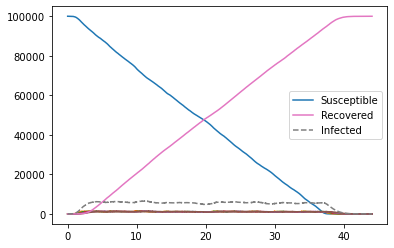

In [181]:
tot_history = np.array(test_sim.tot_history)
t_vals = np.array(res[0])/24
for i in range(7):
    if i == 0:
        label = 'Susceptible'
    elif i == m+1:
        label = 'Recovered'
    else:
        label = None
    plt.plot(t_vals, tot_history[:,i], label=label)
    
plt.plot(t_vals, np.sum(tot_history[:,1:6], axis=1), 
         '--', label='Infected')
plt.legend();

In [185]:
# Get time differences for adjacent cities
delta_t_test = []
for i in range(L-1):
    delta_t = test_sim.I_peak_time_diff(i+1,i)
    delta_t_test.append(delta_t)

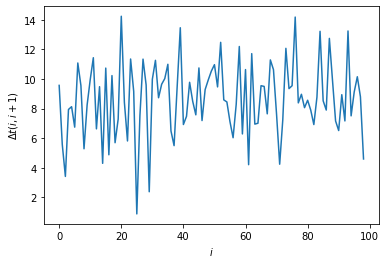

In [186]:
plt.plot(np.arange(L-1), delta_t_test)
plt.xlabel(r'$i$')
plt.ylabel(r'$\Delta t(i,i+1)$')
plt.show();

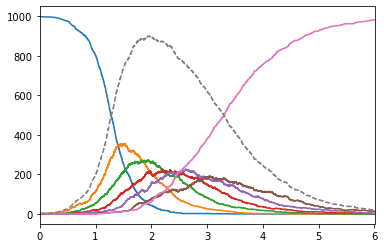

In [211]:
for r in range(m+2):
    plt.plot(np.array(res[0])/24,res[1][:,0,r])
plt.plot(np.array(res[0])/24, np.sum(res[1][:,0,1:m+1], axis=-1), '--')
    
plt.xlim(left=0, right=6);

### RM Model

In [389]:
test_sim_RM = SimRMHuman(N, I_0, M=linear_chain_M, 
                      m=m, beta=beta, gamma=gamma)

In [390]:
res_RM = test_sim_RM.run(tol=int(1e5))

Process finished in 2.0 minutes and 53 seconds.


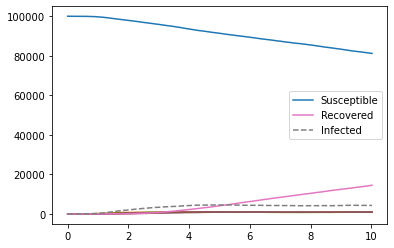

In [391]:
tot_history = np.array(test_sim_RM.tot_history)
t_vals = np.array(res_RM[0])/24
for i in range(7):
    if i == 0:
        label = 'Susceptible'
    elif i == m+1:
        label = 'Recovered'
    else:
        label = None
    plt.plot(t_vals, tot_history[:,i], label=label)
    
plt.plot(t_vals, np.sum(tot_history[:,1:6], axis=1), 
         '--', label='Infected')
plt.legend();

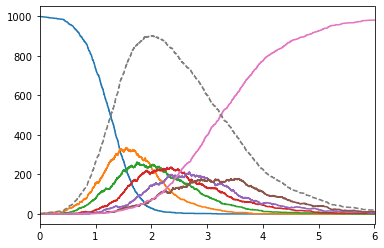

In [392]:
for r in range(m+2):
    plt.plot(np.array(res_RM[0])/24, res_RM[1][:,0,r])
plt.plot(np.array(res_RM[0])/24, np.sum(res_RM[1][:,0,1:m+1], axis=-1), '--')
    
plt.xlim(left=0, right=6);